In [84]:
### Library Imports
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")


In [85]:
### Import S&P500 Data
def get_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for ticker in tickers:
        data[ticker] = yf.download(ticker, start_date, end_date)['Adj Close']
    
    return data

### Return Stock Data
tickers = ['NVDA']  # Ticker symbol for the S&P 500
start_date = '2019-08-01'
end_date = '2024-08-01'
stock_data = get_data(tickers, start_date, end_date)
print(stock_data.tail())

# Get most recent stock price
s_0 = stock_data['NVDA'].iloc[-1]
print('The most recent stock price is: ', round(s_0, 4))

[*********************100%%**********************]  1 of 1 completed

                  NVDA
Date                  
2024-07-25  112.279999
2024-07-26  113.059998
2024-07-29  111.589996
2024-07-30  103.730003
2024-07-31  117.019997
The most recent stock price is:  117.02


In [86]:
### Set input parameters
# Option parameters
T = 1.0          # Time to maturity (in years)
r = 0.05         # Risk-free rate
n_simulations = 100  # Number of simulations
n_steps = 252    # Number of time steps (252 trading days in a year)
dt = T / n_steps # Time increment

# Determine strike price
K = 115 # lookback_call or barrier_call (5% increase over current stock price (bullish))
print('The pre-determined option strike price is:', round(K, 4))

# Compute Sigma - stddev * sqrt(252)
daily_rets = stock_data.pct_change().dropna()
#print(daily_rets.tail())
sigma = daily_rets['NVDA'].std() * np.sqrt(252)
print('The computed sigma is: ', round(sigma, 4))


The pre-determined option strike price is: 115
The computed sigma is:  0.5316


In [87]:
### Simulate Price Paths
def price_paths(S0, T, r, sigma, dt, n_steps, n_simulations):
    # Initialize the array for storing simulated stock price paths
    S = np.zeros((n_steps + 1, n_simulations))
    S[0] = S0
    # Set the seed for reproducibility
    np.random.seed(42)
    # Simulate price paths
    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_simulations)
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    return S

### Display Price Paths
paths = price_paths(s_0, T, r, sigma, dt, n_steps, n_simulations)
print(paths)

'''
S = np.array([
    [100, 102, 101],  # Prices at t=0 for each simulation path
    [105, 103, 104],  # Prices at t=1
    [110, 105, 107],  # Prices at t=2
])
So, path 1 at all time steps = [100, 105, 110]
    S[-1] would give the last row: [110, 105, 107] -> times at t = 2
    S[-1, 0] would give 110, which is the final price for the first simulation path.
    S[-1, 1] would give 105, the final price for the second simulation path.
'''

[[117.01999664 117.01999664 117.01999664 ... 117.01999664 117.01999664
  117.01999664]
 [118.9395573  116.43727465 119.54237758 ... 118.00467331 116.99764713
  116.06231798]
 [113.39286354 114.76709963 118.13554424 ... 118.57072208 117.18346132
  111.66371602]
 ...
 [140.65644647  39.51669424 141.30868946 ... 299.88358968 116.22291937
   82.65526997]
 [141.4123316   39.5185969  139.2327508  ... 318.29209346 112.83616086
   81.10147674]
 [142.71538166  39.16701666 138.71685135 ... 317.29137703 107.9856962
   80.48370059]]


'\nS = np.array([\n    [100, 102, 101],  # Prices at t=0 for each simulation path\n    [105, 103, 104],  # Prices at t=1\n    [110, 105, 107],  # Prices at t=2\n])\nSo, path 1 at all time steps = [100, 105, 110]\n    S[-1] would give the last row: [110, 105, 107] -> times at t = 2\n    S[-1, 0] would give 110, which is the final price for the first simulation path.\n    S[-1, 1] would give 105, the final price for the second simulation path.\n'

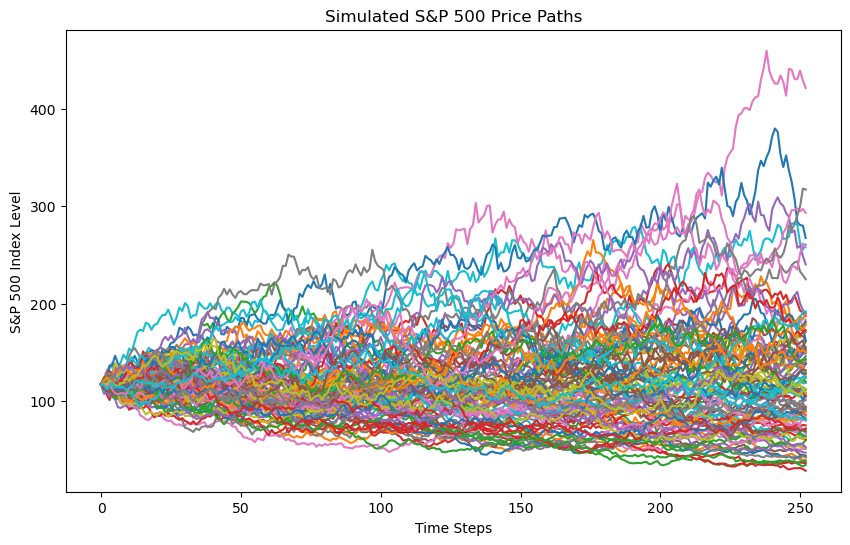

In [88]:
### Plot Price Paths
def plot_paths(price_paths, n_simulations):
    # Plot some simulated paths
    plt.figure(figsize = (10, 6))
    # Iterate 
    for t in range(n_simulations):
        plt.plot(price_paths[:, t])
    
    plt.title('Simulated S&P 500 Price Paths')
    plt.xlabel('Time Steps')
    plt.ylabel('S&P 500 Index Level')
    plt.show()

plot_paths(paths, n_simulations)

In [89]:
### Calculate Avg Asset Price for each period t
def avg_price(paths):
    # Array initialization
    avg_path = []
    # Iterate to calculate avg price over time (for each time step)
    for t in range(paths.shape[0]):
        avg_path.append(paths[t, :].mean())

    return avg_path

avg_price_path = avg_price(paths)
print('Last 5 average computed price path values:')
print(avg_price_path[-5:])
print('The average computed price at the last period is: $', round(avg_price_path[-1], 4))
#print(len(avg_price_path))


Last 5 average computed price path values:
[123.98974729245418, 123.48705240497252, 123.67425427722395, 123.5384221268294, 123.06676637292794]
The average computed price at the last period is: $ 123.0668


In [100]:
### American Option Pricing using LSMC
def least_squares_mc(S, K, r, dt, option_type='put'):
    ## Var declaration and discount factor calculation
    n_steps, n_simulations = S.shape
    discount_factor = np.exp(-r * dt)
    # Initialize an array to store the optimal exercise time for each path
    exercise_times = np.full(n_simulations, np.nan)  # Start with NaN for paths that might not be exercised

    ## Calculate payoffs at maturity (-1)
    '''
    S[-1]: This accesses the last row of the S matrix, which contains the final prices of the underlying asset at maturity for all the simulation paths.
    K - S[-1]: This computes the intrinsic value (the payoff if exercised) of a put option at maturity for each simulation path.
    np.maximum(K - S[-1], 0): This ensures that the payoff is non-negative. If the option is out-of-the-money (i.e., S[-1] > K), the payoff is 0.
    '''
    if option_type == 'call':
        payoffs = np.maximum(S[-1] - K, 0) 
    elif option_type == 'put':
        payoffs = np.maximum(K - S[-1], 0)
    
    ## Backward Induction: The LSMC method works backward from the maturity date to the current date:
    '''
    Regression: For each time step, a regression is performed to estimate the continuation value based on the simulated paths.
    Exercise Decision: The option holder compares the immediate exercise value to the continuation value to decide whether to exercise the option or hold it.
    '''
    # Starting at last position (n_steps - 2), decrement by 1 to 0
    for t in range(n_steps - 2, 0, -1): 
        # Identify in-the-money paths
        itm = np.where(payoffs > 0)[0] # Create a 1D array containing the indices of the paths that are in-the-money

        ## Regression to estimate continuation value for in-the-money paths
        # Extracts the prices of the underlying asset at time step t for all paths that are currently in-the-money
        X = S[t, itm].reshape(-1, 1)
        # Calculate the discounted payoffs at the next time step
        y = payoffs[itm] * discount_factor
        regression = LinearRegression().fit(X, y)
        # Predict the continuation value for the current in-the-money paths
        '''
        Continuation value represents the expected value of holding the option until a future point in time, rather than exercising it immediately.
        C_t ​= E[Payoff at time t+1 | Current price] * e^(-rΔt)
        '''
        continuation_value = regression.predict(X)

        ## Exercise value at time t
        if option_type == 'call':
            exercise_value = np.maximum(S[t, itm] - K, 0) 
        elif option_type == 'put':
            exercise_value = np.maximum(K - S[t, itm], 0)
        
        ## Update payoffs: Take the max of immediate exercise or continuation
        '''
        np.where(condition, x, y)
        Condition: exercise_value > continuation_value - This checks if the immediate exercise value of the option is greater than the continuation value.
        x = exercise_value: If the condition is True, it means it's optimal to exercise the option now, so the payoff is set to the immediate exercise value.
        y = payoffs[itm] * discount_factor: If the condition is False, it means it's better to hold the option. The payoff is then updated to reflect 
                                            the continuation value (i.e., the current payoff discounted to the next time step).
        '''
        optimal_exercise = exercise_value > continuation_value
        payoffs[itm] = np.where(exercise_value > continuation_value, exercise_value, payoffs[itm] * discount_factor)
        #print(payoffs)

        # Update the exercise times array with the current time step for those paths where it's optimal to exercise
        exercise_times[itm[optimal_exercise]] = t
    
    ## Calculate the option price as the average of discounted payoffs
    option_price = np.mean(payoffs) * discount_factor

    ## Calculate average exercise time and early exercise probability
    avg_ex_time = np.nanmean(exercise_times)  # Mean of the non-NaN values
    early_ex_prob = np.sum(~np.isnan(exercise_times)) / n_simulations

    return option_price, avg_ex_time, early_ex_prob


### Function call
option_value, avg_exercise_time, early_exercise_prob = least_squares_mc(paths, K, r, dt, option_type='put')

print('The computed option value is: $' + str(round(option_value, 4)))
print('The average exercise time is:', round(avg_exercise_time, 2))
print('The early exercise probability is:', round(early_exercise_prob * 100, 2), '%')


The computed option value is: $18.5657
The average exercise time is: 153.0
The early exercise probability is: 26.0 %
